# UMAP of SSL Embeddings (SimCLR on STL-10)

Goal: visualize the structure of learned representations.
We load a trained SimCLR checkpoint, extract the encoder, compute embeddings for the **labeled** STL-10 split,
then project embeddings to 2D using UMAP.

> This is an analysis notebook — no traininghere.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
EMB_DIR = ARTIFACTS_DIR / "embeddings"
FIG_DIR = ARTIFACTS_DIR / "figures"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("EMB_DIR:", EMB_DIR)

PROJECT_ROOT: D:\ML\SSL
EMB_DIR: D:\ML\SSL\artifacts\embeddings


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import umap

from sklearn.decomposition import PCA
from torch.utils.data import DataLoader

from src.data.stl10_datamodule import STL10DataModule
from src.models.simclr import SimCLR 
from src.utils.embeddings import load_simclr_from_ckpt, infer_encoder_from_simclr, compute_embeddings, save_embeddings_npz
from src.utils.seed import set_seed

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
runs_df = pd.read_csv(METRICS_DIR / "runs_index.csv")
assert not runs_df.empty, "runs_index.csv empty"

run = runs_df.iloc[-1].to_dict()
run_id = run["run_id"]
method = run["method"]
version_dir = PROJECT_ROOT / Path(run["version_dir"])

print("run_id:", run_id)
print("method:", method)
print("version_dir:", version_dir)

# Чекпоинты — у вас могут быть в artifacts/checkpoints или внутри version_dir.
# ПРИОРИТЕТ: версия-специфичная папка, потом общий checkpoints.
ckpt_candidates = list(version_dir.glob("*.ckpt")) + list((ARTIFACTS_DIR / "checkpoints").rglob("*.ckpt"))
assert len(ckpt_candidates) > 0, "No .ckpt found in version_dir or artifacts/checkpoints"

# выбираем "последний по времени"
ckpt_path = max(ckpt_candidates, key=lambda p: p.stat().st_mtime)
print("Using checkpoint:", ckpt_path)

run_id: simclr_version_0
method: simclr
version_dir: D:\ML\SSL\artifacts\logs\simclr\version_0
Using checkpoint: D:\ML\SSL\artifacts\checkpoints\simclr\last.ckpt


In [4]:
simclr_model = load_simclr_from_ckpt(
    ckpt_path=ckpt_path,
    device=device,
    model_cls=SimCLR,
    strict=True,
)

encoder = infer_encoder_from_simclr(simclr_model).to(device).eval()
encoder

D:\Anaconda\envs\ssl_env\lib\site-packages\lightning\fabric\utilities\cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


ResNet18Encoder(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [5]:
dm = STL10DataModule(
    data_dir=str(PROJECT_ROOT / "data"),
    batch_size=256,
    num_workers=4,
    image_size=96,
    pin_memory=True,
)

dm.prepare_data()
dm.setup()

assert dm.eval_train is not None, "dm.eval_train is None (expected STL10 split='train')"
assert dm.eval_test is not None,  "dm.eval_test is None (expected STL10 split='test')"

eval_train_loader = DataLoader(
    dm.eval_train,
    batch_size=dm.batch_size,
    shuffle=False,
    num_workers=dm.num_workers,
    pin_memory=dm.pin_memory,
    persistent_workers=(dm.num_workers > 0),
    prefetch_factor=2 if dm.num_workers > 0 else None,
)

eval_test_loader = DataLoader(
    dm.eval_test,
    batch_size=dm.batch_size,
    shuffle=False,
    num_workers=dm.num_workers,
    pin_memory=dm.pin_memory,
    persistent_workers=(dm.num_workers > 0),
    prefetch_factor=2 if dm.num_workers > 0 else None,
)

eval_train_loader

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
pack_train = compute_embeddings(
    dataloader=eval_train_loader,
    encoder=encoder,
    device=device,
    normalize=True,
    max_batches=None,   
)
print("Eval-train embeddings:", pack_train.z.shape, "labels:", pack_train.y.shape)

emb_path = EMB_DIR / f"{run_id}_eval_train.npz"
save_embeddings_npz(
    emb_path,
    pack_train,
    meta={"run_id": run_id, "method": method, "split": "eval_train"},
)
print("Saved:", emb_path)

Eval-train embeddings: (5000, 512) labels: (5000,)
Saved: D:\ML\SSL\artifacts\embeddings\simclr_version_0_eval_train.npz


In [7]:
Z = pack_train.z
Y = pack_train.y.astype(int)

Z_pca = PCA(n_components=min(50, Z.shape[1]), random_state=42).fit_transform(Z)

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
Z_2d = reducer.fit_transform(Z_pca)
method_2d = "UMAP"

Z_2d.shape, method_2d

D:\Anaconda\envs\ssl_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


((5000, 2), 'UMAP')

Saved figure: D:\ML\SSL\artifacts\figures\umap_simclr_version_0.png


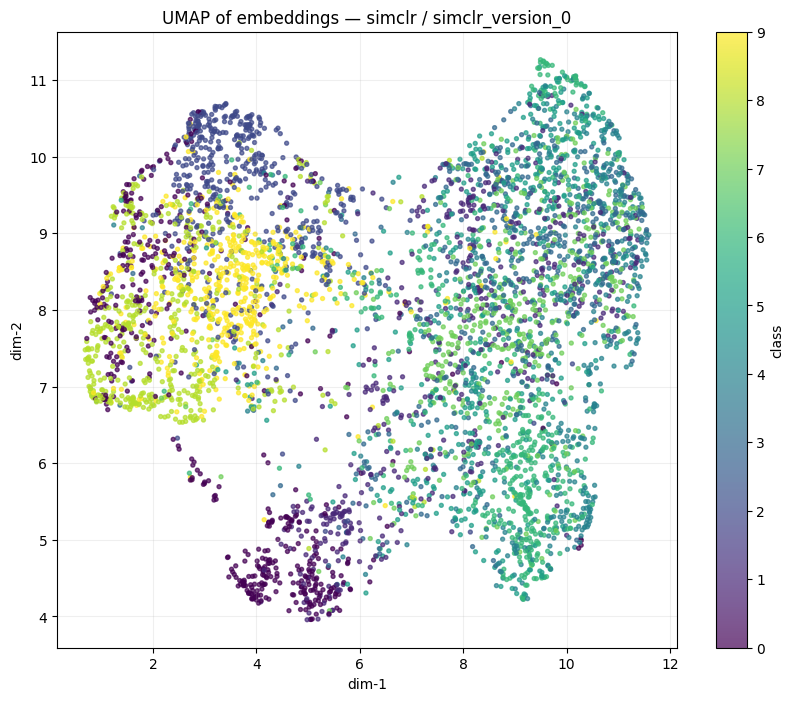

In [8]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=Y, s=8, alpha=0.7)
plt.title(f"{method_2d} of embeddings — {method} / {run_id}")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.grid(True, alpha=0.2)
plt.colorbar(scatter, label="class")

out = FIG_DIR / f"umap_{run_id}.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
print("Saved figure:", out)

plt.show()

# Conclusions & Observations

In this notebook we visualized representations learned by a SimCLR model trained on the STL-10 unlabeled split.

## What was done

- Loaded a trained SimCLR checkpoint and extracted the encoder backbone.

- Computed embeddings for the labeled STL-10 train split using frozen weights.

- Applied dimensionality reduction (PCA → UMAP) to project embeddings into 2D.

- Visualized the embedding space with points colored by ground-truth class labels.

## Observations

- Even after a short training run (few epochs), the embedding space already shows
non-random structure.

- Samples belonging to the same class tend to form local clusters, although class
boundaries are still fuzzy.

- This behavior is expected at this stage: the goal of this run was pipeline validation,
not maximal representation quality.

### Importantly, the visualization confirms that:

- the encoder learned meaningful invariances from unlabeled data,

- embeddings are suitable for similarity-based tasks (retrieval, kNN),

- the overall SSL pipeline works end-to-end.

## Limitations

- The model was trained for a small number of epochs.

- No quantitative downstream evaluation (kNN / linear probe) was performed here.

- UMAP visualization is qualitative and should not be interpreted as a strict metric.

## Next steps

- Retrieval demo: show nearest neighbors in embedding space.

- Quantitative evaluation:

- kNN classification on frozen embeddings,

- linear probe evaluation.

## Scaling experiments (optional):

- longer training,

- comparison with BYOL.

## Takeaway

This notebook demonstrates that even a lightweight SSL training run is sufficient to
produce structured and meaningful representations, validating the core idea of
self-supervised learning in this project.